In [1]:
%matplotlib notebook
from DataGenerator import * 
from network import LocalNet, LocalNetOutputMultiRuleModel
from BrainNet import BrainNet
from LocalNetBase import Options, UpdateScheme
import matplotlib.pyplot as plt
from train import train_local_rule, train_vanilla, train_given_rule
import numpy as np
from train import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Lambda(lambda x : x.flatten().double())])
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [10]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = True, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = True,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

local_net = LocalNet(784, 10, num_v = 100, p = .5, cap = 50, rounds = 0, step_sz=1e-2, options = options, update_scheme = scheme)
# local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
# local_net.set_rnn_rule(torch.tensor([[0.15, -0.12, 0.20, -0.06],
#                                      [0.44, 0.08, 0.47, -0.11],
#                                      [0.26, 0.43, 1.41, -0.77],
#                                      [0.19, -0.54, 0.16, -0.31]]))

losses = []
optimizer = torch.optim.Adam(local_net.parameters(), lr=1e-2, weight_decay = 0.01)
#local_net.rule.detach().reshape(16, 16)

In [11]:
for i in range(20):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        loss = local_net(inputs, labels, 10, 10, continue_=False)
        losses += [loss.item()]
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.96

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [12]:
rule_2 = np.array([[0.15, -0.12, 0.20, -0.06], 
                   [0.44, 0.08, 0.47, -0.11], 
                   [0.26, 0.43, 1.41, -0.77], 
                   [0.19, -0.54, 0.16, -0.31]])

rule_4 = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        rule_4[i, j] = rule_2[i // 4, j//4] + rule_2[i % 8 // 2, j % 8 // 2] + rule_2[i % 4, j % 4]

In [13]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = False, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

local_net = LocalNet(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 0, step_sz=1e-2, options = options, update_scheme = scheme)
local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1]]))
# local_net.set_rnn_rule(rule)

losses = []

In [14]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = local_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = local_net(inputs, labels, 1, 1, continue_=True)
        losses += [loss.item()]
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.95

Test Accuracy: 10.240%
Epoch 0 Batch 0: 760.792
Epoch 0 Batch 100: 76.355
Epoch 0 Batch 200: 44.193
Epoch 0 Batch 300: 39.955
Epoch 0 Batch 400: 32.524
Epoch 0 Batch 500: 34.032
Test Accuracy: 88.580%
Epoch 1 Batch 0: 29.736
Epoch 1 Batch 100: 19.563
Epoch 1 Batch 200: 22.743
Epoch 1 Batch 300: 19.532
Epoch 1 Batch 400: 20.360
Epoch 1 Batch 500: 22.372
Test Accuracy: 90.330%
Epoch 2 Batch 0: 14.717


KeyboardInterrupt: 

In [6]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = True, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )
# step_sz=1e-2,
local_net = LocalNet(784, 10, num_v = 500, p = .5, cap = 250, rounds = 3, options = options, update_scheme = scheme)
# local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1]]))
local_net.set_rnn_rule(torch.tensor(rule_4))
# local_net.set_rnn_rule(rule)

losses = []

C:\Users\sayka\Desktop\Course\Brain\ProjAssemblies\BrainNet\LocalNetBase.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rule = torch.tensor(rule).flatten().double()


In [9]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = local_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = local_net(inputs, labels, 1, 1, continue_=True)
        losses += [loss.item()]
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.96

Test Accuracy: 9.900%
Epoch 0 Batch 0: 10220014.746
Epoch 0 Batch 100: 73897600342.744
Epoch 0 Batch 200: 353642328015.034


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


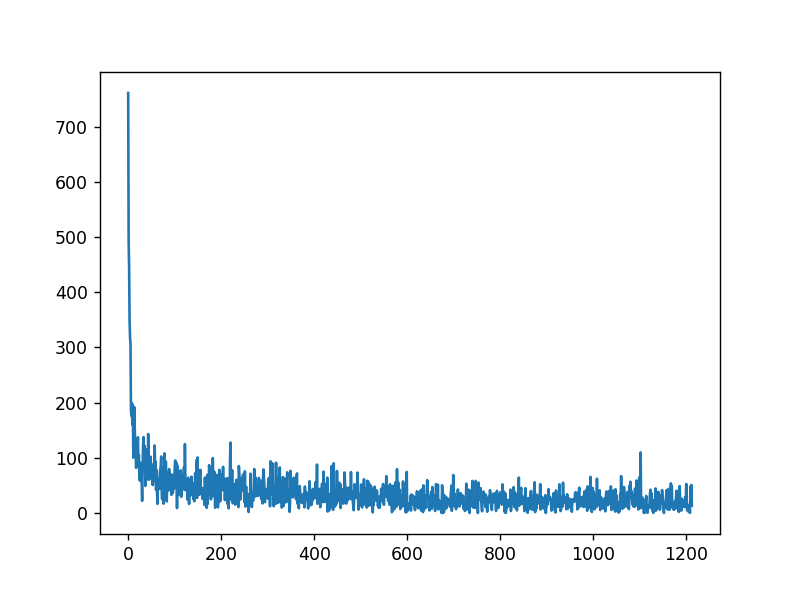

In [15]:
fig, ax = plt.subplots()
ax.plot(losses)

In [5]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = local_net.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 91.020%


<IPython.core.display.Javascript object>


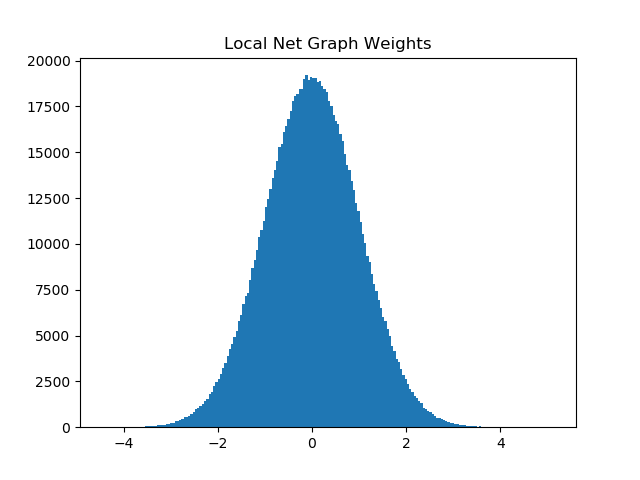

Text(0.5, 1.0, 'Local Net Graph Weights')

In [6]:
fig, ax = plt.subplots()
ax.hist(local_net.graph_weights.numpy().flatten(), bins=200)
ax.set_title('Local Net Graph Weights')

<IPython.core.display.Javascript object>


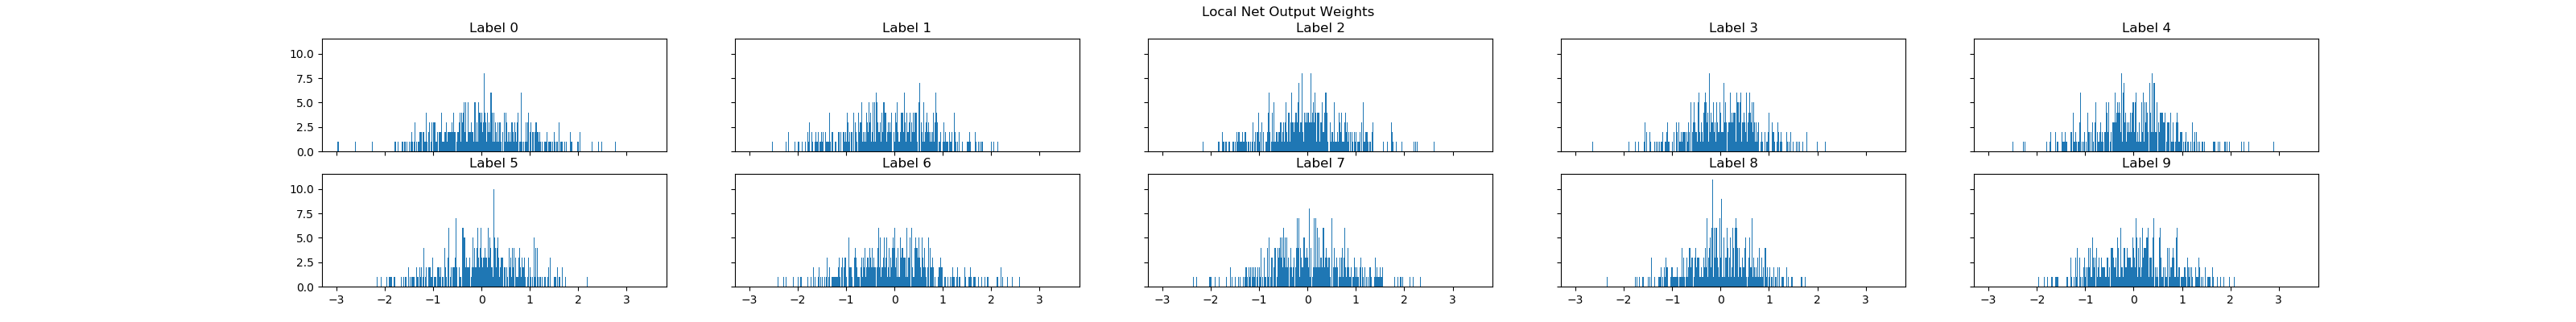

Text(0.5, 0.98, 'Local Net Output Weights')

In [7]:
weights = local_net.output_weights.numpy()
fig, axes = plt.subplots(2, 5, figsize=(32, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=1000, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('Local Net Output Weights')

In [16]:
for i in range(10):
    print(np.count_nonzero(np.histogram(weights[i], bins=1000, range=(-3, 3))[0]))

252
268
235
216
225
247
229
259
242
211


In [7]:
gd_net = BrainNet(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 3, gd_output = True, gd_graph=True                )
gd_net.input_layer = local_net.input_layer
gd_net.input_weights = local_net.input_weights
# gd_net.graph_weights = local_net.graph_weights
gd_net.graph = local_net.graph
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gd_net.parameters(), lr=1e-2)
losses = []

In [8]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = gd_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        optimizer.zero_grad()
        outputs = gd_net.forward_pass(inputs)
        loss = criterion(outputs, labels)
        losses += [loss.item()]
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))

RuntimeError: The size of tensor a (500) must match the size of tensor b (1000) at non-singleton dimension 0

In [12]:
gd_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = gd_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('GD Net Test Accuracy: {:.3f}%'.format(gd_correct / len(testset) * 100))

GD Net Test Accuracy: 87.490%


<IPython.core.display.Javascript object>


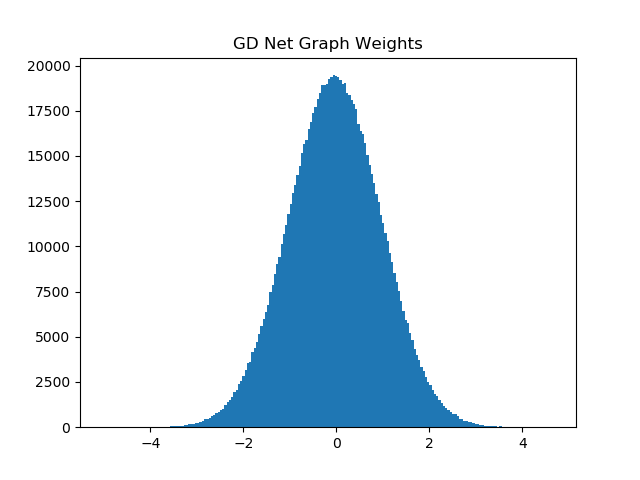

Text(0.5, 1.0, 'GD Net Graph Weights')

In [13]:
fig, ax = plt.subplots()
ax.hist(gd_net.graph_weights.detach().numpy().flatten(), bins=200)
ax.set_title('GD Net Graph Weights')

<IPython.core.display.Javascript object>


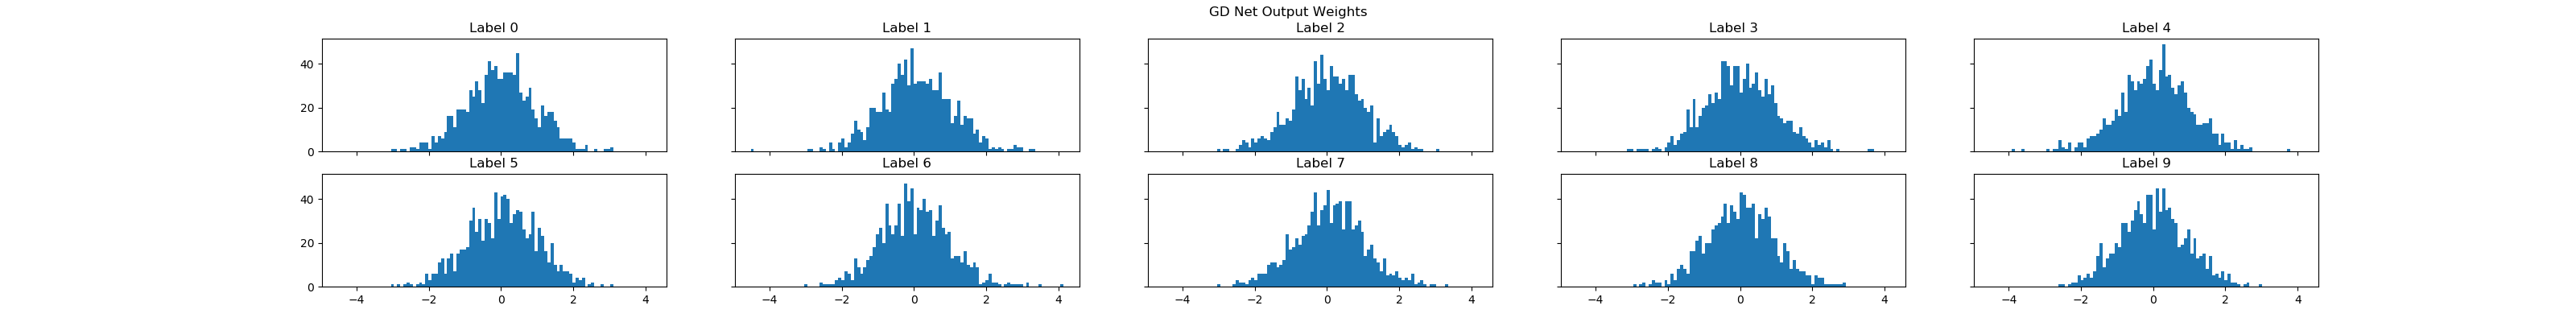

Text(0.5, 0.98, 'GD Net Output Weights')

In [14]:
weights = gd_net.output_weights.detach().numpy()
fig, axes = plt.subplots(2, 5, figsize=(32, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=100, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('GD Net Output Weights')

In [15]:
for i in range(10):
    print(np.count_nonzero(np.histogram(weights[i], bins=1000, range=(-max(-weights.min(), weights.max()), max(-weights.min(), weights.max())))[0]))

394
388
395
391
397
389
382
395
377
383


In [16]:
from AdversarialExamples import adversarial_example

idx = np.full(10, -1, dtype=int)
for i, data in enumerate(testset):
    input, label = data
    print(i)
    with torch.no_grad():
        local_pred = local_net.forward_pass(input.reshape(1, -1)).argmax()
        #gd_pred = gd_net.forward_pass(input.reshape(1, -1)).argmax()
        #and gd_pred == label 
        if local_pred == label and idx[label] < 0:
            print("caught")
            idx[label] = i
    if np.all(idx >= 0):
        print('Appropriate samples found')
        break

0
caught
1
caught
2
caught
3
caught
4
caught
5
6
7
caught
8
9
10
11
caught
12
13
14
15
caught
16
17
18
caught
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
caught
Appropriate samples found


In [17]:
idx

array([ 3,  2,  1, 18,  4, 15, 11,  0, 61,  7])

In [18]:
inputs = []
for i in idx:
    data = testset[i]
    input, label = data
    inputs += [input.reshape(1, -1)]
inputs = torch.cat(inputs, dim=0)
print(inputs.shape)

torch.Size([10, 784])


In [26]:
from AdversarialExamples import adversarial_example
%load_ext autoreload
%autoreload 2
local_adv_ex = torch.Tensor(10, 10, 784)
gd_adv_ex = torch.Tensor(10, 10, 784)
for i in range(10):
    for j in range(10):
        print(j)
        if i == j:
            local_adv_ex[i, j] = inputs[i].squeeze()
            #gd_adv_ex[i, j] = inputs[i].squeeze()
        else:
            local_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), local_net.forward_pass, lr=1e-3,eps=4)
            #gd_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), gd_net.forward_pass, lr=1e-2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


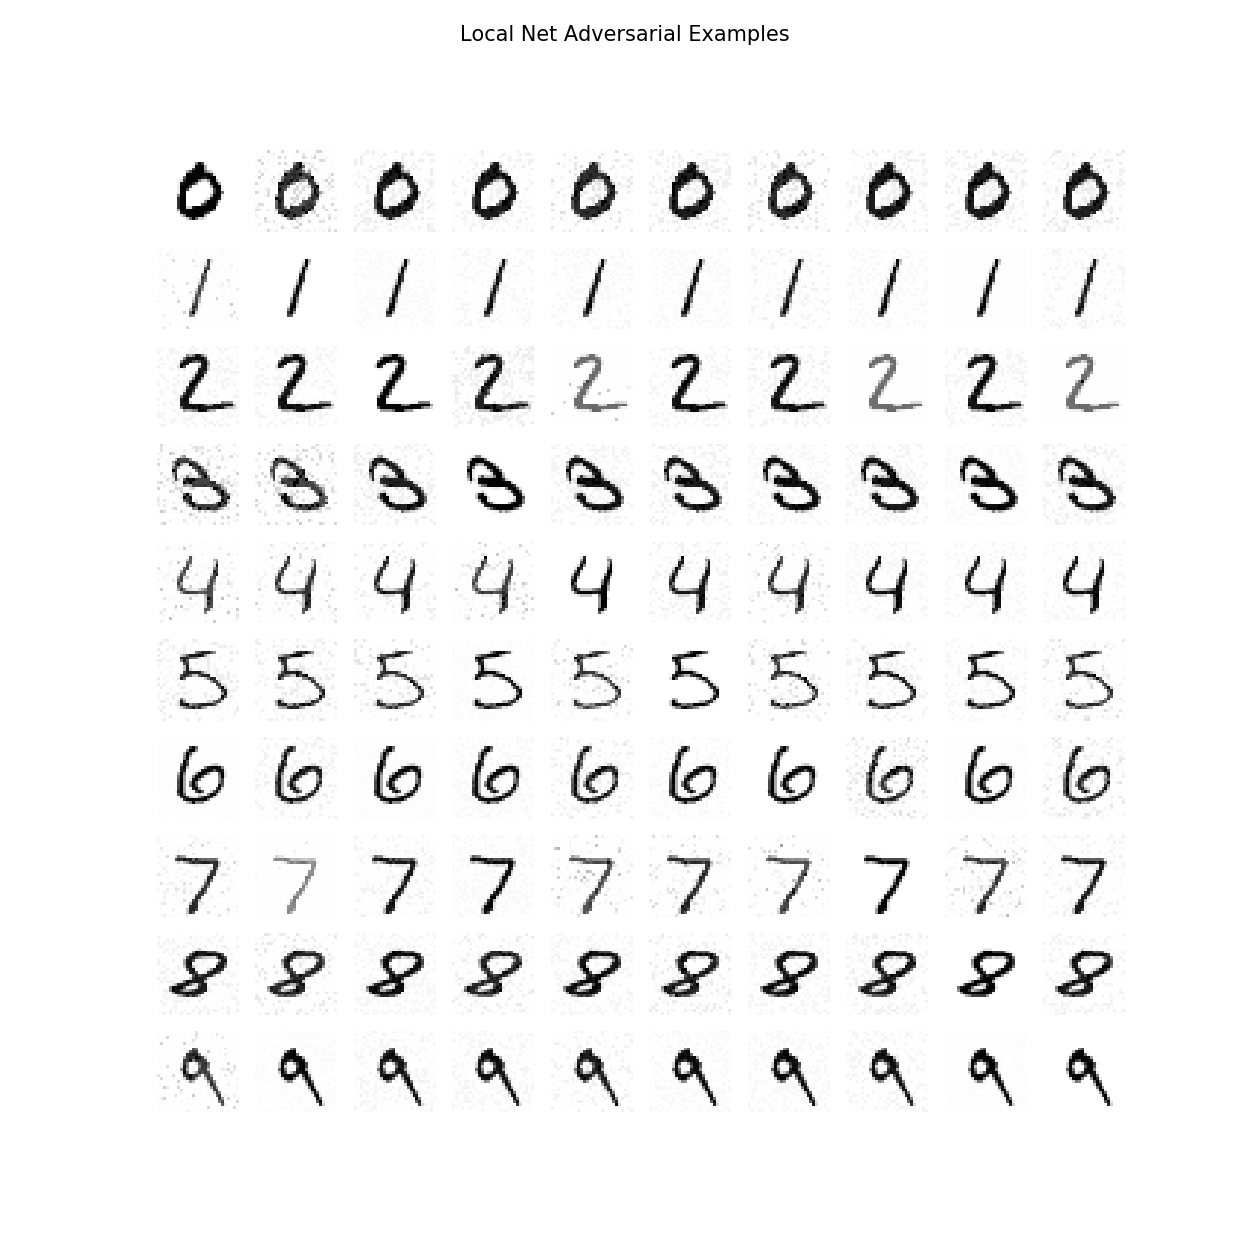

Text(0.5, 0.98, 'Local Net Adversarial Examples')

In [27]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(local_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
        ax.set_axis_off()
        
fig.suptitle('Local Net Adversarial Examples')

<IPython.core.display.Javascript object>


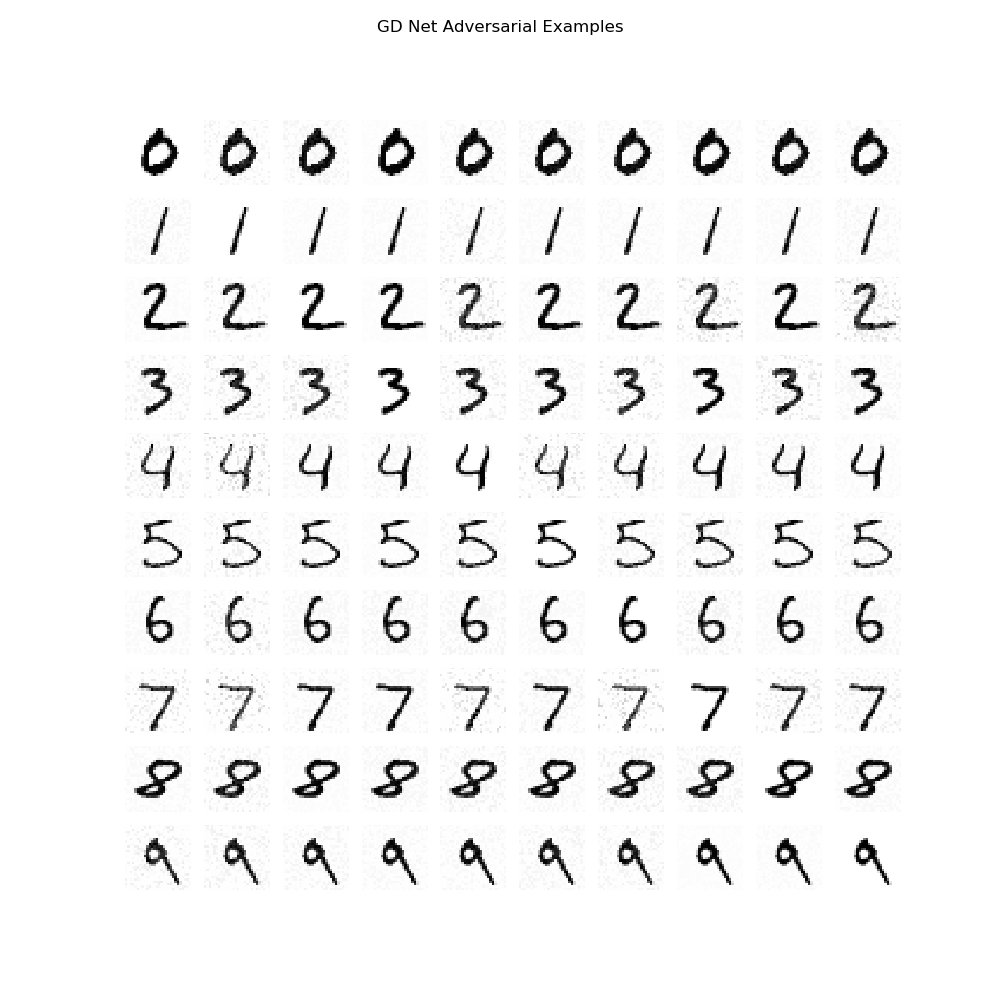

Text(0.5, 0.98, 'GD Net Adversarial Examples')

In [23]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(gd_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
        ax.set_axis_off()
        
fig.suptitle('GD Net Adversarial Examples')

<IPython.core.display.Javascript object>


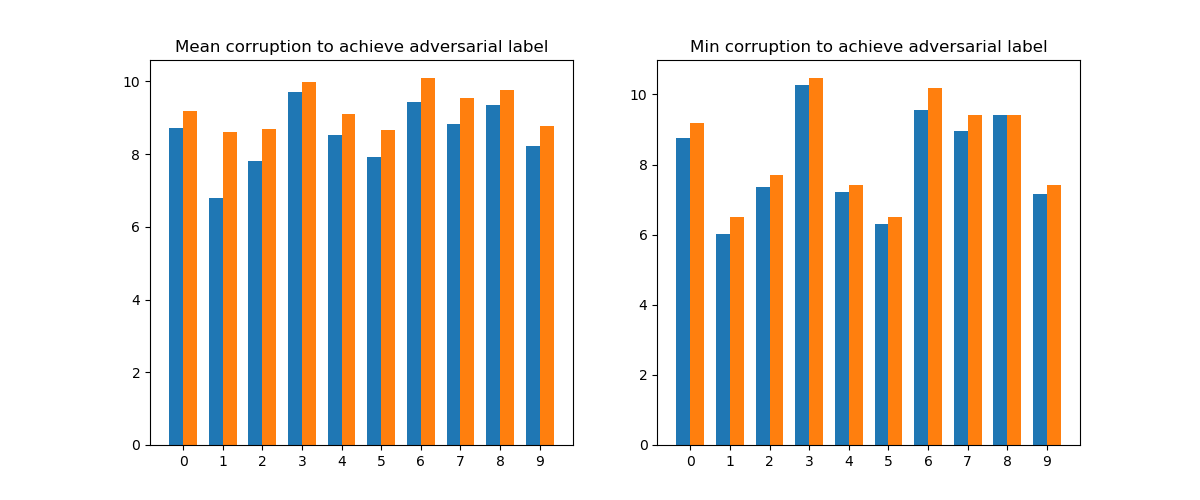

Text(0.5, 1.0, 'Min corruption to achieve adversarial label')

In [83]:
local_mag = torch.norm(inputs.reshape(1, 10, -1) - local_adv_ex.detach(), dim=-1)
gd_mag = torch.norm(inputs.reshape(1, 10, -1) - gd_adv_ex.detach(), dim=-1)

width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(np.arange(10) - width/2, local_mag.mean(dim=0), width=width, label='Local')
axes[0].bar(np.arange(10) + width/2, gd_mag.mean(dim=0), width=width, label='GD')
axes[0].set_xticks(np.arange(10))
axes[0].set_title('Mean corruption to achieve adversarial label')

axes[1].bar(np.arange(10) - width/2, (local_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='Local')
axes[1].bar(np.arange(10) + width/2, (gd_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='GD')
axes[1].set_xticks(np.arange(10))
axes[1].set_title('Min corruption to achieve adversarial label')

In [4]:
meta_model = LocalNetOutputMultiRuleModel(784, 10, num_v = 500, p = .5, cap = 250, rounds = 0, step_sz=1e-5, options = options)
optimizer = torch.optim.Adam(meta_model.output_rule_model.parameters(), lr=1e-3)
losses = []

/home/max/Projects/Learning Plasticity Rules/network.py:229: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.edges = (self.graph > 0).nonzero()


In [5]:
for i in range(5):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = meta_model(inputs, labels, 1, 1)
        loss.backward()
        optimizer.step()
        losses += [loss.item()]
        if j % 100 == 0:
            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

0 0: 2.303
0 100: 2.262
0 200: 1.816


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


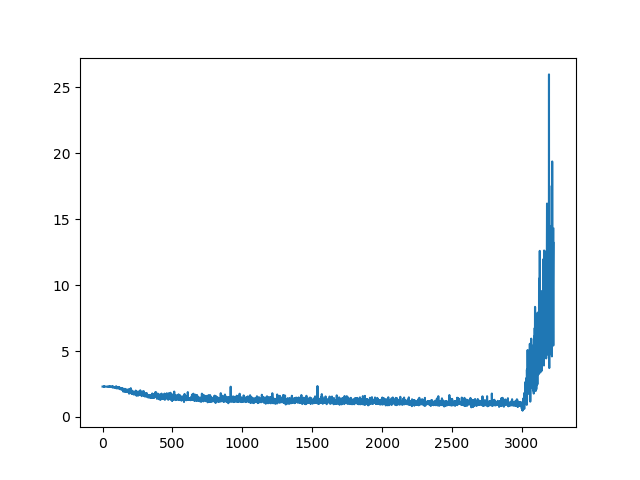

In [70]:
fig, ax = plt.subplots()
ax.plot(losses)

In [67]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = meta_model.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 67.050%


In [69]:
for i in range(15):
    for j, data in enumerate(trainloader):
        inputs, labels = data
#         if i == 0 and j == 0:
#             continue_ = False
#         else:
        continue_ = True
        loss = meta_model(inputs, labels, 1, 1, continue_=False)
        losses += [loss.item()]
        if j % 100 == 0:
            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

0 0: 0.646
0 100: 1.968
0 200: 9.661


KeyboardInterrupt: 

In [213]:
np.savez_compressed('models/localnet_mnist_rnn_outputrule.npz', 
                    input_weights=local_net.input_weights.numpy(), 
                    graph_weights=local_net.graph_weights.numpy(),
                    output_weights=local_net.output_weights.numpy())

In [10]:
np.savez_compressed('models/gdnet_mnist_rnn_outputrule.npz', 
                    input_weights=gd_net.input_weights.detach().numpy(), 
                    graph_weights=gd_net.graph_weights.detach().numpy(),
                    output_weights=gd_net.output_weights.detach().numpy())